본 강좌에서는 간단한 순환 신경망 모델을 만들어봅니다. 늘 그렇듯이 다음과 같은 순서로 진행하겠습니다.

1. 데이터셋 준비하기
1. 모델 구성하기
1. 모델 엮기
1. 모델 학습시키기
1. 모델 평가하기

---

### 데이터셋 살펴보기

The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem1. The dataset was constructed from a number of scanned document datasets available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.
Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required. Each image is a 28 ⇥ 28 pixel square (784 pixels total). A standard split of the dataset is used to
1http://yann.lecun.com/exdb/mnist/
    121
19.2. Loading the MNIST dataset in Keras 122
evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.
It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy. Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks. There is a listing of the state-of-the-art results and links to the relevant papers on the MNIST and other datasets on Rodrigo Benenson’s webpage2.

In [ ]:
'''Example script showing how to use stateful RNNs
to model long sequences efficiently.
'''
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 25
# number of elements ahead that are used to make the prediction
lahead = 1

def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

print('Generating Data')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape')
print(expected_output.shape)

---

### 모델 구성하기

Next we define our neural network model. Convolutional neural networks are more complex than standard Multilayer Perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state-of-the-art results. Below summarizes the network architecture.
1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5 ⇥ 5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above.
2. Next we define a pooling layer that takes the maximum value called MaxPooling2D. It is configured with a pool size of 2 ⇥ 2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function is used.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.
As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm. A depiction of the network structure is provided below.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Create model

model = Sequential()
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))

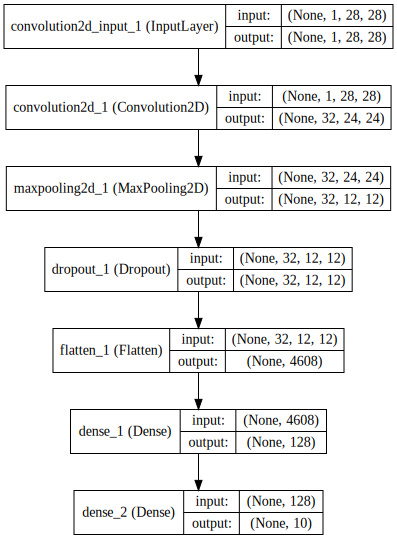

In [6]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

# brew install graphviz
# pip uninstall -y pydot
# pip install pydot-ng

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![svg]({{ site.baseurl }}/posts_warehouse/2017-2-4-CNN_Getting_Started-2.svg)

### 모델 엮기

컴파일 시에 정의해야하는 것들
- 가중치 세트를 평가하는 데 사용할 손실함수(loss function)
 - binary_crossentropy : 이진 분류를 위한 logarithmic loss
- 네트워크의 다른 가중치를 검객하는 데 사용되는 최적화 알고리즘
 - adam : 효율적인 경사 하강법(gradient descent) 알고리즘
- 학습과정에서 수집하기 싶은 측정 기준

In [7]:
# Compile model
model.compile(loss='mse', optimizer='rmsprop')

### 모델 학습시키기

- nb_epoch : 데이터셋에 대한 반복 횟수
- batch_size : 네트워크에서 가중치 개갱신 전에 평가되는 인스턴스의 수

In [8]:
# Fit the model

print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              nb_epoch=1,
              shuffle=False)
    model.reset_states()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
89s - loss: 0.2065 - acc: 0.9369 - val_loss: 0.0759 - val_acc: 0.9758
Epoch 2/10
88s - loss: 0.0644 - acc: 0.9805 - val_loss: 0.0466 - val_acc: 0.9833
Epoch 3/10
91s - loss: 0.0447 - acc: 0.9862 - val_loss: 0.0395 - val_acc: 0.9880
Epoch 4/10
93s - loss: 0.0348 - acc: 0.9889 - val_loss: 0.0356 - val_acc: 0.9889
Epoch 5/10
63s - loss: 0.0269 - acc: 0.9915 - val_loss: 0.0339 - val_acc: 0.9892
Epoch 6/10
61s - loss: 0.0213 - acc: 0.9934 - val_loss: 0.0401 - val_acc: 0.9875
Epoch 7/10
57s - loss: 0.0186 - acc: 0.9943 - val_loss: 0.0353 - val_acc: 0.9885
Epoch 8/10
61s - loss: 0.0143 - acc: 0.9953 - val_loss: 0.0334 - val_acc: 0.9895
Epoch 9/10
89s - loss: 0.0123 - acc: 0.9960 - val_loss: 0.0378 - val_acc: 0.9888
Epoch 10/10
101s - loss: 0.0108 - acc: 0.9963 - val_loss: 0.0364 - val_acc: 0.9893


---
### 모델 평가하기

In [9]:
# evaliuate

print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

print('Plotting Results')
plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()

CNN Error: 1.07%


---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/2017/01/27/Keras_Lecture_Plan/)
* 이전 : [딥러닝 기본 실습/다층 퍼셉트론 모델 만들어보기](https://tykimos.github.io/Keras/2017/02/04/MLP_Getting_Started/)
* 다음 : [딥러닝 기본 실습/오토인코더 모델 만들어보기](https://tykimos.github.io/Keras/2017/02/04/AutoEncoder_Getting_Started/)